In [28]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

In [3]:
df = pd.read_excel('cleaned_dataset.xlsx')

# Idenficando outliers 

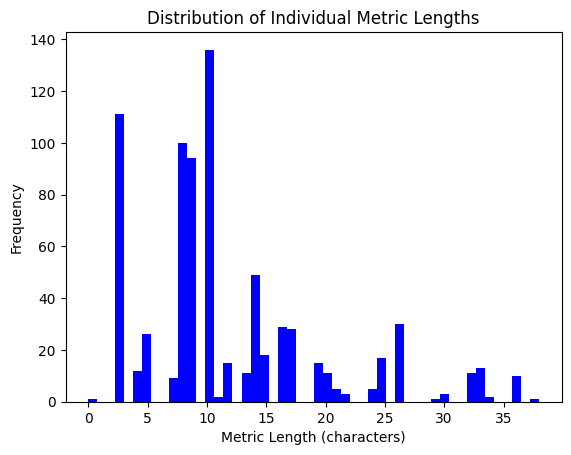

Potential outlier metrics:
Outliers in row 2: ['Quantidade de solicitações de clientes']
Outliers in row 5: ['Security Test Pass Rate (security']
Outliers in row 12: ['Team total effective available hours']
Outliers in row 17: ['Security Test Pass Rate (security']
Outliers in row 24: ['Indicator about risky user stories']
Outliers in row 33: ['Indicator about risky user stories']
Outliers in row 61: ['Security Test Pass Rate (security']
Outliers in row 65: ['Team total effective available hours']
Outliers in row 67: ['Team total effective available hours', 'Team total effective available hours']
Outliers in row 76: ['Security Test Pass Rate (security']
Outliers in row 86: ['Security Test Pass Rate (security']
Outliers in row 87: ['Security Test Pass Rate (security']
Outliers in row 89: ['Security Test Pass Rate (security', 'Security Test Pass Rate (security']
Outliers in row 90: ['Security Test Pass Rate (security']
Outliers in row 107: ['Security Test Pass Rate (security']
Outliers in

In [18]:
import itertools

def get_metric_lengths(sanitized_metrics):
    # Split the metrics by comma and strip leading/trailing spaces
    metrics = [metric.strip() for metric in sanitized_metrics.split(',')]
    # Return the length of each metric
    return [len(metric) for metric in metrics]

# Step 2: Apply the function to get a list of metric lengths for each row
df['metric_lengths'] = df['sanitized_metrics'].apply(get_metric_lengths)

# Step 3: Flatten the list of all metric lengths across the entire dataset for analysis
all_metric_lengths = list(itertools.chain.from_iterable(df['metric_lengths']))

# Step 4: Visualize the distribution of individual metric lengths
plt.hist(all_metric_lengths, bins=50, color='blue')
plt.title('Distribution of Individual Metric Lengths')
plt.xlabel('Metric Length (characters)')
plt.ylabel('Frequency')
plt.show()

# Step 5: Define and detect outliers based on individual metric lengths

# Convert the list of all metric lengths into a pandas Series for easier analysis
metric_lengths_series = pd.Series(all_metric_lengths)

# Calculate the IQR (interquartile range) for the metric lengths
Q1 = metric_lengths_series.quantile(0.25)
Q3 = metric_lengths_series.quantile(0.75)
IQR = Q3 - Q1

# Define outlier bounds with a relaxed threshold (2.5 times the IQR)
threshold_multiplier = 2.5
lower_bound = Q1 - threshold_multiplier * IQR
upper_bound = Q3 + threshold_multiplier * IQR

# Step 6: Function to find outliers in each row based on the length of individual metrics
def find_outliers(row, lower_bound, upper_bound):
    # Split the metrics and calculate lengths again
    metrics = [metric.strip() for metric in row.split(',')]
    # Find metrics that are outside the bounds
    outlier_metrics = [metric for metric in metrics if len(metric) < lower_bound or len(metric) > upper_bound]
    return outlier_metrics

# Apply the function to find outlier metrics for each row
df['outlier_metrics'] = df['sanitized_metrics'].apply(find_outliers, args=(lower_bound, upper_bound))

# Step 7: Filter the rows that actually contain outlier metrics and display only the outlier metrics
outlier_rows = df[df['outlier_metrics'].apply(lambda x: len(x) > 0)]

# Print only the outlier metrics
print("Potential outlier metrics:")
for index, row in outlier_rows.iterrows():
    print(f"Outliers in row {index}: {row['outlier_metrics']}")

/var/folders/5j/0g6pzkwj7_g1p9xwqx5jfgq80000gn/T/ipykernel_36680/1700959354.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_metric_rows['num_unique_metrics'] = unique_metric_rows['unique_metrics'].apply(len)


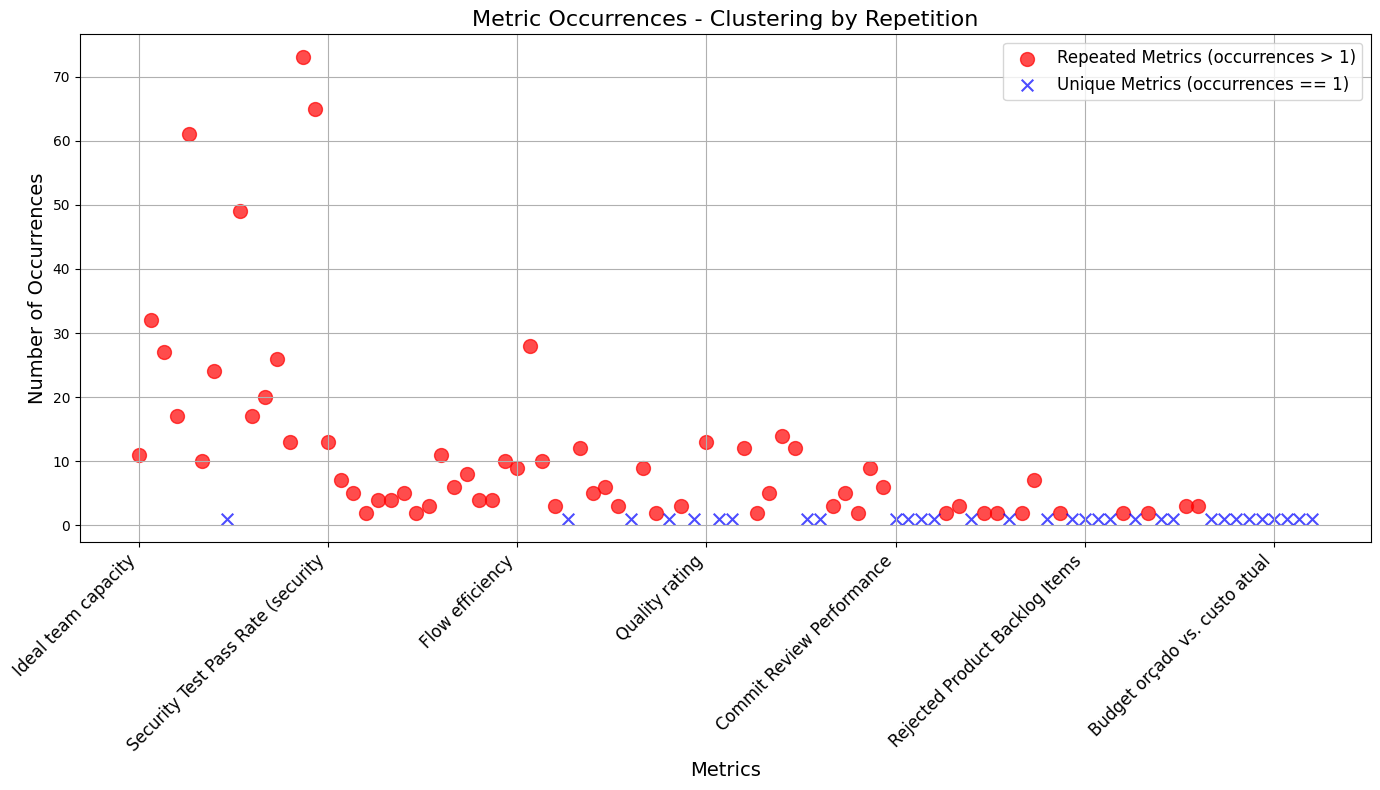

In [21]:
from collections import Counter

# Step 1: Define a function to split metrics and clean them
def split_metrics(sanitized_metrics):
    return [metric.strip() for metric in sanitized_metrics.split(',')]

# Step 2: Apply the function to split metrics in each row
df['metrics_list'] = df['sanitized_metrics'].apply(split_metrics)

# Step 3: Flatten all the lists of metrics into a single list
all_metrics = [metric for sublist in df['metrics_list'] for metric in sublist]

# Step 4: Count the occurrences of each metric using Counter
metric_counts = Counter(all_metrics)

# Step 5: Identify metrics that appear only once (do not repeat)
unique_metrics = [metric for metric, count in metric_counts.items() if count == 1]

# Step 6: Find rows containing these unique metrics
def find_unique_metrics(row, unique_metrics):
    return [metric for metric in row if metric in unique_metrics]

# Apply the function to find unique metrics for each row
df['unique_metrics'] = df['metrics_list'].apply(find_unique_metrics, args=(unique_metrics,))

# Filter rows that contain unique metrics
unique_metric_rows = df[df['unique_metrics'].apply(lambda x: len(x) > 0)]

# Step 7: Count the number of unique metrics per row
unique_metric_rows['num_unique_metrics'] = unique_metric_rows['unique_metrics'].apply(len)

metric_names = list(metric_counts.keys())
metric_occurrences = list(metric_counts.values())

# Step 6: Separate repeated metrics from unique ones
repeated_metrics = [occurrence > 1 for occurrence in metric_occurrences]

# Step 7: Plot the scatter plot
plt.figure(figsize=(14, 8))

# Plot repeated metrics (occurrences > 1) in a different color
plt.scatter(
    [i for i in range(len(metric_names)) if repeated_metrics[i]], 
    [metric_occurrences[i] for i in range(len(metric_occurrences)) if repeated_metrics[i]],
    color='red', label='Repeated Metrics (occurrences > 1)', s=100, alpha=0.7, marker='o')

# Plot unique metrics (occurrences == 1) in a different color and marker
plt.scatter(
    [i for i in range(len(metric_names)) if not repeated_metrics[i]],
    [metric_occurrences[i] for i in range(len(metric_occurrences)) if not repeated_metrics[i]],
    color='blue', label='Unique Metrics (occurrences == 1)', s=70, alpha=0.7, marker='x')

# Customizing the plot
plt.title('Metric Occurrences - Clustering by Repetition', fontsize=16)
plt.xlabel('Metrics', fontsize=14)
plt.ylabel('Number of Occurrences', fontsize=14)

# Rotate x-axis labels, but only show every nth label to reduce clutter
num_labels_to_show = 15  # Show every 15th label to avoid overcrowding
plt.xticks(
    ticks=[i for i in range(len(metric_names)) if i % num_labels_to_show == 0],
    labels=[metric_names[i] for i in range(len(metric_names)) if i % num_labels_to_show == 0],
    rotation=45, ha='right', fontsize=12)

# Add a grid, legend, and adjust layout for better visualization
plt.grid(True)
plt.legend(fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()


In [23]:
most_common_metrics = metric_counts.most_common()
print("Most common metrics (sorted by occurrences):")
for metric, count in most_common_metrics:
    if count > 1:
        print(f"{metric}: {count} occurrences")

Most common metrics (sorted by occurrences):
Cycle time: 73 occurrences
Lead time: 65 occurrences
Throughput: 61 occurrences
Velocity: 49 occurrences
NPS: 32 occurrences
Métricas ágeis: 28 occurrences
Burndown: 27 occurrences
Conversão: 26 occurrences
OKR: 24 occurrences
Roadmaps: 20 occurrences
Outstanding bugs: 17 occurrences
CAC: 17 occurrences
Team total available hours: 14 occurrences
User Story Points: 13 occurrences
Security Test Pass Rate (security: 13 occurrences
Quality rating: 13 occurrences
CFD: 12 occurrences
KPI: 12 occurrences
Project avg. cost: 12 occurrences
Ideal team capacity: 11 occurrences
Team and individual motivational: 11 occurrences
Number of remaining tasks: 10 occurrences
Team total effective available hours: 10 occurrences
Number of Active Customers: 10 occurrences
Flow efficiency: 9 occurrences
Churn: 9 occurrences
CSAT: 9 occurrences
Valor agregado: 8 occurrences
Test Coverage: 7 occurrences
Dívidas técnicas: 7 occurrences
Technical Efficiency: 6 occurren

In [24]:
# Step 7: Print the outlier metrics (those that occur only once)
print("\nOutlier metrics (appear only once):")
for metric, count in most_common_metrics:
    if count == 1:
        print(f"{metric}: {count} occurrence")


Outlier metrics (appear only once):
Quantidade de solicitações de clientes: 1 occurrence
Effort estimation accuracy: 1 occurrence
Running Tested Features Metric: 1 occurrence
BoardColumn: 1 occurrence
Evolução (Cognitiva-Científica: 1 occurrence
Pulse: 1 occurrence
Burn-up: 1 occurrence
Role Time Measure: 1 occurrence
Hours spent on bugs: 1 occurrence
Commit Review Performance: 1 occurrence
Change failure rate: 1 occurrence
CES: 1 occurrence
Taxas de exceções: 1 occurrence
Faturamento: 1 occurrence
Queue impediments size: 1 occurrence
Leads: 1 occurrence
Compliance: 1 occurrence
Rejected Product Backlog Items: 1 occurrence
EAC: 1 occurrence
Transações: 1 occurrence
9box: 1 occurrence
SRE: 1 occurrence
Telas por sessão: 1 occurrence
Taxa de Retenção: 1 occurrence
Time in meeting: 1 occurrence
Curva S: 1 occurrence
: 1 occurrence
Critical bugs: 1 occurrence
Budget orçado vs. custo atual: 1 occurrence
Cost Devitation: 1 occurrence
Lei de Little: 1 occurrence
Tempo de resposta: 1 occurren

In [31]:
def split_metrics(sanitized_metrics):
    return [metric.strip() for metric in sanitized_metrics.split(',')]

# Step 2: Apply the function to split metrics in each row
df['metrics_list'] = df['sanitized_metrics'].apply(split_metrics)

# Step 3: Flatten all the lists of metrics into a single list
all_metrics = [metric for sublist in df['metrics_list'] for metric in sublist]

# Step 4: Count the occurrences of each metric using Counter
metric_counts = Counter(all_metrics)

# Step 5: Identify the outlier metrics (metrics that appear only once)
outlier_metrics = [metric for metric, count in metric_counts.items() if count == 1]

# Step 6: Find rows that contain outlier metrics and save them
def find_outlier_rows(row_metrics, outlier_metrics):
    return [metric for metric in row_metrics if metric in outlier_metrics]

# Apply the function to find outlier metrics in each row
df['outlier_metrics'] = df['metrics_list'].apply(find_outlier_rows, args=(outlier_metrics,))

# Filter rows that contain any outlier metrics
outlier_rows = df[df['outlier_metrics'].apply(lambda x: len(x) > 0)]

# Step 7: Save the outliers to a new Excel file
outlier_rows_to_save = outlier_rows[['outlier_metrics', 'sanitized_metrics']].copy()
outlier_rows_to_save['row_id'] = outlier_rows.index  # Save the original row IDs

# Save the outliers to an Excel file
outlier_rows_to_save.to_excel('outliers_metrics.xlsx', index=False)

# Step 8: Remove the outlier metrics from the 'sanitized_metrics' column
def remove_outliers_from_metrics(row_metrics, outlier_metrics):
    # Return the list of metrics that are not outliers
    return [metric for metric in row_metrics if metric not in outlier_metrics]

df['cleaned_metrics'] = df['metrics_list'].apply(remove_outliers_from_metrics, args=(outlier_metrics,))

# Join the cleaned metrics back into a string to recreate the 'sanitized_metrics' column
df['sanitized_metrics'] = df['cleaned_metrics'].apply(lambda x: ', '.join(x))

# Drop the helper columns
df.drop(columns=['metrics_list', 'outlier_metrics', 'cleaned_metrics'], inplace=True)
df.drop(columns=['text_length', 'metric_lengths', 'unique_metrics', 'num_unique_metrics'], errors='ignore', inplace=True)

# Save the cleaned dataset back to Excel
df.to_excel('cleaned_dataset_no_outlier_metrics.xlsx', index=False)

# Content based filtering

In [37]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.preprocessing import StandardScaler

# Load the dataset
data = pd.read_excel('cleaned_dataset_no_outlier_metrics.xlsx')

data.drop(columns=['Carimbo de data/hora'], errors='ignore', inplace=True)
# Display the first few rows of the dataset to inspect
data.head()

,id_integer,role,years_exp,org_size,org_field,agile_methods,use_metrics_planning,use_metrics_review,use_metrics_weekly,use_metrics_daily,use_metrics_retro,use_metrics_na,metrics_category,sanitized_metrics
0,1,Product manager,0 a 5,Microempresa,energia,"Scrum, Kanban",Métricas,NaN,Métricas,NaN,NaN,NaN,"Cronograma e progresso, Produto, Tecnologia, C...",Ideal team capacity
1,2,Desenvolvedor(a),0 a 5,Microempresa,Financeiro,"Scrum, Kanban",Métricas,Métricas,NaN,NaN,NaN,NaN,"Cronograma e progresso, Produto, Cliente","NPS, Burndown, Outstanding bugs, Throughput, N..."
2,3,Product manager,0 a 5,Pequena empresa,Eventos,Scrum,Gerenciamento de riscos,Métricas,NaN,Gerenciamento de riscos,"Gerenciamento de riscos, Métricas",NaN,"Cronograma e progresso, Pessoas, Produto","Burndown, OKR, Velocity"
3,4,Team leader,6 a 9,Microempresa,gestão,"Scrum, Kanban","Gerenciamento de riscos, Métricas",Gerenciamento de riscos,Gerenciamento de riscos,Gerenciamento de riscos,Métricas,NaN,"Cronograma e progresso, Produto, Cliente","CAC, Throughput, Roadmaps, Conversão"
4,5,Product manager,0 a 5,Pequena empresa,Agronegocio,"Scrum, Kanban","Gerenciamento de riscos, Métricas",Métricas,NaN,NaN,Métricas,NaN,Cronograma e progresso,"User Story Points, NPS"


In [38]:
print(data.isnull().sum())

# Check for duplicates
print(data.duplicated().sum())

# Describe the dataset to see distribution of numerical columns
print(data.describe())

id_integer                0
role                      0
years_exp                 3
org_size                  3
org_field                 0
agile_methods             0
use_metrics_planning     26
use_metrics_review       65
use_metrics_weekly       86
use_metrics_daily        77
use_metrics_retro        58
use_metrics_na          193
metrics_category          0
sanitized_metrics         1
dtype: int64
0
       id_integer
count  210.000000
mean   129.180952
std     78.723583
min      1.000000
25%     61.750000
50%    124.500000
75%    194.750000
max    281.000000


In [57]:
data.drop(columns=['use_metrics_planning','use_metrics_review','use_metrics_weekly','use_metrics_daily','use_metrics_retro','use_metrics_na'], errors='ignore', inplace=True)

data['role'] = data['role'].astype('category').cat.codes
data['org_field'] = data['org_field'].astype('category').cat.codes
data['agile_methods'] = data['agile_methods'].astype('category').cat.codes
data['metrics_category'] = data['metrics_category'].astype('category').cat.codes
data['years_exp'] = data['years_exp'].replace({
    '0 a 5': 2.5,
    '6 a 9': 7.5,
    '10 a 20': 15,
    'Mais de 20': 25
})

# Replace company sizes with numerical categories
data['org_size'] = data['org_size'].replace({
    'Microempresa': 1,
    'Pequena empresa': 2,
    'Média empresa': 3,
    'Grande empresa': 4
})

# Convert 'years_exp' and 'org_size' to numeric, force any errors to NaN
data['years_exp'] = pd.to_numeric(data['years_exp'], errors='coerce')
data['org_size'] = pd.to_numeric(data['org_size'], errors='coerce')

# Now let's check which numerical columns contain non-numeric values
numerical_cols = ['years_exp', 'org_size']

# Iterate through numerical columns to find any problematic rows with non-numeric data
for col in numerical_cols:
    non_numeric_rows = data[pd.to_numeric(data[col], errors='coerce').isna()]
    print(f"Non-numeric values in column {col}:")
    print(non_numeric_rows[[col]])

# Apply median to each numerical column
# First ensure all columns are numeric
data[numerical_cols] = data[numerical_cols].apply(pd.to_numeric, errors='coerce')

# Fill missing values with the median
data[numerical_cols] = data[numerical_cols].apply(lambda x: x.fillna(x.median()), axis=0)

# Fill missing values for categorical columns with their most frequent value (mode)
categorical_cols = ['role', 'org_field', 'agile_methods', 'metrics_category']
data[categorical_cols] = data[categorical_cols].apply(lambda x: x.fillna(x.mode()[0]), axis=0)

# Normalize the numerical columns using StandardScaler
scaler = StandardScaler()
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])


# Verify preprocessing steps
data.head()

Non-numeric values in column years_exp:
Empty DataFrame
Columns: [years_exp]
Index: []
Non-numeric values in column org_size:
Empty DataFrame
Columns: [org_size]
Index: []


,id_integer,role,years_exp,org_size,org_field,agile_methods,metrics_category,sanitized_metrics
0,1,16,-1.474897,-3.240057,111,6,25,Ideal team capacity
1,2,8,-1.474897,-3.240057,17,6,19,"NPS, Burndown, Outstanding bugs, Throughput, N..."
2,3,16,-1.474897,-1.951398,16,4,5,"Burndown, OKR, Velocity"
3,4,20,-0.724040,-3.240057,112,6,19,"CAC, Throughput, Roadmaps, Conversão"
4,5,16,-1.474897,-1.951398,1,6,0,"User Story Points, NPS"


In [59]:
features = ['role', 'years_exp', 'org_size', 'org_field', 'agile_methods', 'metrics_category']

X = data[features]
y = data['sanitized_metrics']

# Split the data (80% training, 10% validation, 10% testing)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Check the shapes to ensure the split worked as expected
print(X_train.shape, X_val.shape, X_test.shape)

(168, 6) (21, 6) (21, 6)


In [60]:
X_train_clean = X_train.fillna(X_train.median())

# Function to clean user profile by filling NaN values with the median of X_train
def clean_user_profile(user_profile, X_train_clean):
    """Fill NaN values in the user profile using the training data's median."""
    return user_profile.fillna(X_train_clean.median())

# Function to recommend metrics based on user's profile (from X_train)
def recommend_metrics(user_profile, X_train_clean, cosine_sim):
    # Clean the user profile (fill NaN values)
    user_features = clean_user_profile(user_profile, X_train_clean).values.reshape(1, -1)
    
    # Get similarity scores using the cleaned data
    similarity_scores = linear_kernel(user_features, X_train_clean)

    # Get indices of the most similar metrics based on cosine similarity
    top_matches = similarity_scores.argsort()[0][-5:][::-1]  # Get top 5 matches
    
    # Recommend metrics based on top matches
    recommended_metrics = [y_train.iloc[i] for i in top_matches]
    
    return recommended_metrics

# Step to ensure no NaN values in y_train before using TfidfVectorizer
y_train_clean = y_train.fillna("")

# Fit and transform the sanitized metrics using TF-IDF vectorizer
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(y_train_clean)

# Calculate similarity matrix using cosine similarity
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

# Example usage of the recommendation function
user_profile_clean = clean_user_profile(X_test.iloc[0], X_train_clean)  # Clean user profile

# Recommend metrics
recommended_metrics = recommend_metrics(user_profile_clean, X_train_clean, cosine_sim)

print("Recommended Metrics: ", recommended_metrics)

Recommended Metrics:  ['OKR', 'Throughput, Lead time', 'Ideal team capacity', 'CAC, Throughput, Roadmaps, Conversão', 'User Story Points, Velocity, Throughput']


In [61]:
# Function to evaluate the model performance
def evaluate_model(X_val, y_val, X_train, cosine_sim):
    correct_recommendations = 0
    total = len(X_val)

    for i in range(total):
        user_profile = X_val.iloc[i]
        recommended_metrics = recommend_metrics(user_profile, X_train, cosine_sim)

        # Assuming we're doing a simple match check for evaluation
        if y_val.iloc[i] in recommended_metrics:
            correct_recommendations += 1

    accuracy = correct_recommendations / total
    print(f"Accuracy of the recommendation system: {accuracy * 100:.2f}%")

# Evaluate on validation data
evaluate_model(X_val, y_val, X_train, cosine_sim)

# Final test evaluation (after tuning on validation)
evaluate_model(X_test, y_test, X_train, cosine_sim)

Accuracy of the recommendation system: 0.00%
Accuracy of the recommendation system: 4.76%
